# Imports

In [1]:
# pip install autogluon

In [40]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from autogluon.tabular import TabularDataset, TabularPredictor

# Load Data

In [3]:
df = pd.read_pickle("../../FantasyData/data-frames/df_basic_ngs_snaps_adv_1999_2023.pkl")

# Filter By Position

In [4]:
df_wr = df.copy().query("position == 'WR'")
print(f"Length of wide receiver data set: {len(df_wr)}")

Length of wide receiver data set: 5039


In [5]:
# remove our na's
df_wr.dropna(subset="Draft Year", inplace=True)
print(f"After removing NA draft rows, data set size: {len(df_wr)}")

After removing NA draft rows, data set size: 4809


In [6]:
df_wr['Draft_Year'] = df_wr['Draft Year'].astype(str).str.replace('s', '')
df_wr["Draft_Year"] = df_wr["Draft_Year"].astype(int)

df_wr["Draft_Round"] = df_wr["Draft Round"].astype(str).str.replace('Undrafted', '8')
df_wr["Draft_Round"] = df_wr["Draft_Round"].astype(int)

df_wr["Draft_Overall"] = df_wr["Draft Overall"].astype(str).str.replace('Undrafted', '400')
df_wr["Draft_Overall"] = df_wr["Draft_Overall"].astype(int)

# WR Relveant Columns

In [7]:
wr_cols = [
    'player_id', 'season',         
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
    'wopr_x', 'fantasy_points', 'fantasy_points_ppr',
    'games', 'tgt_sh', 'ay_sh', 'yac_sh', 'wopr_y', 'ry_sh', 'rtd_sh',
    'rfd_sh', 'rtdfd_sh', 'dom', 'w8dom', 'yptmpa', 'ppr_sh', 
    'position', 'player_name', 'age', 'team', 'rank', 'tier', 
    'Draft_Year', 'Draft_Round', 'Draft_Overall',
    'Draft Team', 'College', 'avg_cushion', 'avg_separation',
    'avg_intended_air_yards_receiving', 'percent_share_of_intended_air_yards', 
    'catch_percentage', 'yards', 'rec_touchdowns', 'avg_yac', 'avg_expected_yac',
    'avg_yac_above_expectation', 'pfr_player_id', 'offense_snaps', 'offense_pct', 
    'gs_pfr_rec', 'tgt_pfr_rec', 'rec_pfr_rec', 'yds_pfr_rec', 'td_pfr_rec',
    'x1d_pfr_rec', 'ybc_pfr_rec', 'ybc_r_pfr_rec', 'yac_pfr_rec',
    'yac_r_pfr_rec', 'adot_pfr_rec', 'brk_tkl_pfr_rec', 'rec_br_pfr_rec',
    'drop_pfr_rec', 'drop_percent_pfr_rec', 'int_pfr_rec', 'rat_pfr_rec'
]

In [8]:
df_wr = df_wr[wr_cols]

In [9]:
df_wr["yards_per_snap"] = df_wr["receiving_yards"] / df_wr["offense_snaps"]
df_wr["receptions_per_snap"] = df_wr["receiving_yards"] / df_wr["offense_snaps"]

**Note:** Proxy is based on roughly the league median in 2023! This will likely penalize pass happy offenses and improve run happy offenses

Two simplifying assumptions:
 - `freq_pass` is a fair representation of passing across each team in the league
 - `route_proxy` assumes that a WR will be on the field for the same number of rushing and passing plays, proportionally

In [10]:
freq_pass = 0.64
total_passing_snaps = (df_wr["offense_snaps"] / df_wr["offense_pct"]) * freq_pass

df_wr["route_proxy"] = total_passing_snaps * df_wr["offense_pct"]
df_wr["yards_per_route_run"] = df_wr["receiving_yards"] / df_wr["route_proxy"]

**Note:** filtering by snaps automatically removes any data prior to 2012!

In [11]:
df_wr = df_wr.query("games >= 6 and offense_snaps >= 100")

In [12]:
len(df_wr)

1571

# Get Lag Version

For having the previous season as features and fantasy points/receiving first downs be the labels.

In [13]:
def create_lag_df(df, cols_to_filter=3, col_to_increment="season", 
                  cols_to_merge=["player_id", "season"]
    ):
    """"""
    df_now = df.copy()
    df_last = df.copy()

    rename_dict = {}
    for col in list(df_last.columns[cols_to_filter:]):
        rename_dict[col] = f"{col}_last"

    df_last.rename(columns=rename_dict, inplace=True)
    df_last[col_to_increment] += 1

    df_lag = df_now.merge(df_last, how='inner', on=cols_to_merge)

    return df_lag

In [14]:
df_lag = create_lag_df(df_wr.copy(), cols_to_filter=2)

In [15]:
df_lag.query("player_name == 'Mike Evans' and season == 2017")[["player_name", "season", 
                                                                "receiving_yards", "receiving_yards_last"]]

,player_name,season,receiving_yards,receiving_yards_last
509,Mike Evans,2017,1001.0,1321.0


# Select Feature Columns

I.e. the columns with last in them, and of numeric type.

In [16]:
non_numeric_cols = df_lag.select_dtypes(exclude=[np.number]).columns

In [17]:
non_numeric_cols

Index(['player_id', 'position', 'player_name', 'team', 'Draft Team', 'College',
       'pfr_player_id', 'position_last', 'player_name_last', 'team_last',
       'Draft Team_last', 'College_last', 'pfr_player_id_last'],
      dtype='object')

In [18]:
assert(df_lag["Draft_Year"].dtype == 'int64')
assert(df_lag["Draft_Round"].dtype == 'int64')
assert(df_lag["Draft_Overall"].dtype == 'int64')

In [19]:
feature_columns = [
    'receptions_last',
    'targets_last',
    'receiving_yards_last',
    'receiving_air_yards_last',
    'receiving_yards_after_catch_last',
    'receiving_first_downs_last',
    'receiving_epa_last',
    # 'receiving_2pt_conversions_last',
    'racr_last',
    'target_share_last',
    'air_yards_share_last',
    'fantasy_points_last',
    'fantasy_points_ppr_last',
    'games_last',
    'tgt_sh_last',
    'yac_sh_last',
    'w8dom_last',
    'yptmpa_last',
    'ppr_sh_last',
    'age_last',
    'rank_last',
    'tier_last',
    'Draft_Round_last',

    # our metrics
    "yards_per_snap",
    "receptions_per_snap",
    "route_proxy",
    "yards_per_route_run",

    'catch_percentage_last',
    'offense_snaps_last',
    'offense_pct_last',

    
    # 'tgt_pfr_rec_last',
    # 'rec_pfr_rec_last',
    # 'td_pfr_rec_last',
    # 'x1d_pfr_rec_last',
    # 'int_pfr_rec_last',
    # 'rat_pfr_rec_last'
]

In [20]:
label = "fantasy_points_ppr"

In [21]:
cols_to_use = feature_columns + [label]
df_ML = df_lag[cols_to_use].copy()

In [22]:
df_ML.head()

,receptions_last,targets_last,receiving_yards_last,receiving_air_yards_last,receiving_yards_after_catch_last,receiving_first_downs_last,receiving_epa_last,racr_last,target_share_last,air_yards_share_last,...,tier_last,Draft_Round_last,yards_per_snap,receptions_per_snap,route_proxy,yards_per_route_run,catch_percentage_last,offense_snaps_last,offense_pct_last,fantasy_points_ppr
0,45,59,544.0,589.0,148.0,30.0,27.585154,17.371708,1.604753,1.890366,...,5.0,4,1.000000,1.000000,73.60,1.562500,NaN,597.0,0.562667,24.5
1,73,138,1174.0,1832.0,268.0,51.0,25.508378,11.858338,4.521201,6.445839,...,2.0,3,0.967532,0.967532,492.80,1.511769,NaN,911.0,0.891250,162.5
2,64,110,745.0,1219.0,178.0,44.0,24.914914,10.475034,3.743449,4.719369,...,4.0,3,1.295620,1.295620,526.08,2.024407,NaN,770.0,0.780000,219.5
3,79,134,1065.0,1413.0,363.0,45.0,39.161685,13.027294,3.988147,5.097152,...,2.0,3,1.930836,1.930836,222.08,3.016931,NaN,822.0,0.766875,131.0
4,46,73,670.0,719.0,256.0,28.0,22.417599,6.641955,1.752860,2.135309,...,5.0,3,1.108183,1.108183,461.44,1.731536,NaN,347.0,0.694286,183.9


In [23]:
for col in df_ML.columns:
    if "fantasy" in col:
        print(col)

fantasy_points_last
fantasy_points_ppr_last
fantasy_points_ppr


# Create Train, Test, Validation Splits

In [24]:
X = df_ML.iloc[:, :-1]  # features
y = df_ML.iloc[:, -1]   # label

In [25]:
for col in X.columns:
    if "fantasy" in col:
        print(col)

fantasy_points_last
fantasy_points_ppr_last


In [26]:
y[:5]

0     24.5
1    162.5
2    219.5
3    131.0
4    183.9
Name: fantasy_points_ppr, dtype: float64

In [27]:
# First, split into train and temporary sets (train + validation, test)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Now, split the train_temp into actual train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [28]:
print(f"Length of train set: {len(X_train)}")
print(f"Length of test set: {len(X_test)}")
print(f"Length of val set: {len(X_val)}")

Length of train set: 612
Length of test set: 205
Length of val set: 205


# AutoGluon

In [30]:
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [31]:
label_column = 'fantasy_points_ppr'

## Fit

In [32]:
predictor = TabularPredictor(label=label_column).fit(
    train_data=train_data,
    tuning_data=val_data  # Optional, only if you want to use a separate validation set
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240511_002500"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240511_002500"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.7
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:53:34 PST 

## Evaluation

In [33]:
performance = predictor.evaluate(test_data)
print(performance)

{'root_mean_squared_error': -16.23606000037748, 'mean_squared_error': -263.6096443358576, 'mean_absolute_error': -12.371340624553401, 'r2': 0.958153997893325, 'pearsonr': 0.9788646908907025, 'median_absolute_error': -9.73322143554688}


In [34]:
predictions = predictor.predict(test_data.drop(columns=[label_column]))
print(predictions.head())

992    233.463013
478     71.039085
689     12.048156
31     262.448395
617     88.080078
Name: fantasy_points_ppr, dtype: float32


In [37]:
answers = test_data[label_column]

In [38]:
answers.head()

992    227.6
478     46.5
689      5.9
31     242.4
617     77.7
Name: fantasy_points_ppr, dtype: float64

In [41]:
negative = 0
close = 0
far = 0
for guess, answer in zip(predictions, answers):
    diff = guess - answer
    if diff < 0:
        negative += 1
    abs_diff = abs(diff)
    if abs_diff <= 15:
        close += 1
    elif abs_diff >= 30:
        far += 1

In [43]:
print(f"Undershot gusses: {negative}")
print(f"Close guesses: {close}")
print(f"Percent of close guesses: {close / len(answers)}")
print(f"Far guesses: {far}")

Undershot gusses: 91
Close guesses: 138
Percent of close guesses: 0.6731707317073171
Far guesses: 16


## Visualization

In [46]:
errors = abs(predictions - answers)
colors = ['red' if error > 30 else 'green' if error <= 15 else 'blue' for error in errors]

In [87]:
colors = list()
bad_misses = list()
for i, (guess, answer) in enumerate(zip(predictions, answers)):
    if -15 <= (guess - answer) < 0:
        colors.append("green")
    elif 0 <= (guess - answer) <= 15:
        colors.append("green")
    elif abs(guess - answer) >= 30:
        colors.append("red")

        j = answers[answers == answer].index
        player = df_lag.loc[j, 'player_name'].iloc[0]
        season = df_lag.loc[j, 'season'].iloc[0]

        bad_miss = (player, season, guess - answer, guess, answer)
        bad_misses.append(bad_miss)
    else:
        colors.append("orange")

In [88]:
player_names = df_lag.loc[answers.index, 'player_name']
seasons = df_lag.loc[answers.index, 'season']

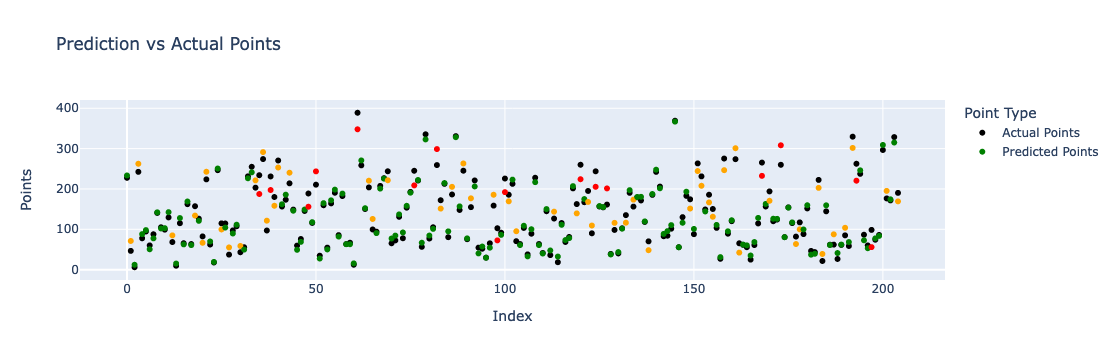

In [89]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add traces for actual values and predicted values
fig.add_trace(go.Scatter(
    x=list(range(len(answers))),
    y=answers,
    mode='markers',
    name='Actual Points',
    marker=dict(color='black'),
    text=player_names + " | " + seasons.astype(str),
    hoverinfo='text+y'
))

fig.add_trace(go.Scatter(
    x=list(range(len(predictions))),
    y=predictions,
    mode='markers',
    name='Predicted Points',
    marker=dict(color=colors),
    text=player_names + " | " + seasons.astype(str),
    hoverinfo='text+y'
))

# Update layout
fig.update_layout(
    title='Prediction vs Actual Points',
    xaxis_title='Index',
    yaxis_title='Points',
    legend_title='Point Type',
    hovermode='closest'
)

# Show the figure
fig.show()

In [95]:
# for player, season, diff, guess, answer in bad_misses:
#     print(f"Missed {player} in {season} by {round(diff, 2)} <br>")
#     print(f"Guess: {round(guess, 2)} <br>")
#     print(f"Answer: {round(answer, 2)} <br>")
#     print()

## Possible Explanations for Misses

Missed **JuJu Smith-Schuster in 2020** by -46.63 <br>
Guess: 187.47 <br>
Answer: 234.1 <br>

9 touchdowns and 97 receptions; Ben atttempt 608 passes; JuJu was alpha? Maybe DJ... Guess is still a large improvement on 2019 production, so in the correct direction

Missed **Adam Thielen in 2023 by -33.62** <br>
Guess: 197.38 <br> 
Answer: 231.0 <br>

4 tds and 103 receptions - only option in Carolina; the guess is still an improvement over 2022, so in the correct direction

Missed **Marvin Jones in 2013 by -32.76** <br>
Guess: 155.94 <br>
Answer: 188.7 <br>

10 tds - still correctly guessed a large improvement from 2012

Missed **Mike Evans in 2015 by 32.93** <br>
Guess: 243.53 <br>
Answer: 210.6 <br>

Expecation was to continue rookie year, production, but we were let down? Seems like touchdown regression hit to drop his year two fantasy production - unsure why the model may have missed here, as he hits all of the key important features...

Missed **Antonio Brown in 2014** by -41.02 <br>
Guess: 347.88 <br>
Answer: 388.9 <br>

Still correctly guessed direction of improvement - Brown just had an insane season, with 13 touchdows, 129 receptions and almost 1700 yards

Missed **Robert Woods in 2020** by -36.3 <br>
Guess: 208.8 <br>
Answer: 245.1 <br>

Incorrectly guessed a decrease. This seems likely due to the model not incorporating rushing numbers and Woods has some decent rushing, aruguably the best rushing year of his career was in 2020. The receiving stats - outside of his jump from 2 to 6 tds - all went down for him in 2020.

Missed **Jaylen Waddle in 2022** by 39.66 <br>
Guess: 298.86 <br>
Answer: 259.2 <br>

Tyreek Hill effect? That being said, Waddle receiving yards did monstrously increase.

Missed **Donte Moncrief in 2016** by -30.1 <br>
Guess: 72.5 <br>
Answer: 102.6 <br>

Did correctly predict a decrease in Moncrieft's ppr production - he had 173 in 2015, and was largely buoyed by his TDs in both seasons

Missed **D.J. Chark in 2019** by -33.67 <br>
Guess: 192.13 <br>
Answer: 225.8 <br>

Off, but did correctly predict a massive boom from the bust of a rookie year, which is interesting...

Missed **Jarvis Landry in 2017** by -35.89 <br>
Guess: 224.11 <br>
Answer: 260.0 <br>

Really buoyed by his (league leading) 112 receptions and 9 td season - model predicted he would essentially tread water from the year before (231.3). Yards did take a large dip.

Missed **Deebo Samuel in 2023** by -38.39 <br>
Guess: 205.31 <br>
Answer: 243.7 <br>

Still in the right direction of guess. Receiving production correctly boomed, but rushing is not accounted for!

Missed **Mike Williams in 2019** by 40.04 <br>
Guess: 201.34 <br>
Answer: 161.3 <br>

Model expected a bigger 3rd year breakout. Tbf, numbers across the board improved - he just had severe touchdown regression (10 to 2). He didn't have the breakout predicted, and actually regressed from a fantasy production perspective.

Missed **Tyler Lockett in 2020** by -32.95 <br>
Guess: 232.45 <br>
Answer: 265.4 <br>

It was expecting water treading. Had an extra 18 receptions and 2 TDs from 2019.

Missed **Julio Jones in 2016** by 48.37 <br>
Guess: 308.27 <br>
Answer: 259.9 <br>

Correctly guessed a decrease from his historic 2015, just not sharp enough. I suspect the large drop in receptions was part of this.

Missed **Mike Evans in 2021** by -42.01 <br>
Guess: 220.49 <br>
Answer: 262.5 <br>

Expected a bit of a decline from 2020. Mike had 13 TDs in 2020. Somehow manage 14 in 2021...

Missed **Cordarrelle Patterson in 2018** by -42.73 <br>
Guess: 55.77 <br>
Answer: 98.5 <br>

We don't factor in rushing... for what it is worth, his receiving production was still garbage...

In [99]:
df_wr.query("player_name == 'Jarvis Landry'")[["season", "receiving_yards", "route_proxy", "fantasy_points_ppr", "offense_snaps"]]

,season,receiving_yards,route_proxy,fantasy_points_ppr,offense_snaps
9936,2014,758.0,437.12,189.40,683.0
9937,2015,1157.0,554.88,275.36,867.0
9938,2016,1136.0,570.88,233.30,892.0
9939,2017,987.0,594.56,260.00,929.0
9940,2018,976.0,612.48,217.12,957.0
9941,2019,1174.0,624.64,237.40,976.0
9942,2020,840.0,447.36,187.96,699.0
9943,2021,570.0,341.12,133.00,533.0
9944,2022,272.0,192.64,60.20,301.0


## Subplots

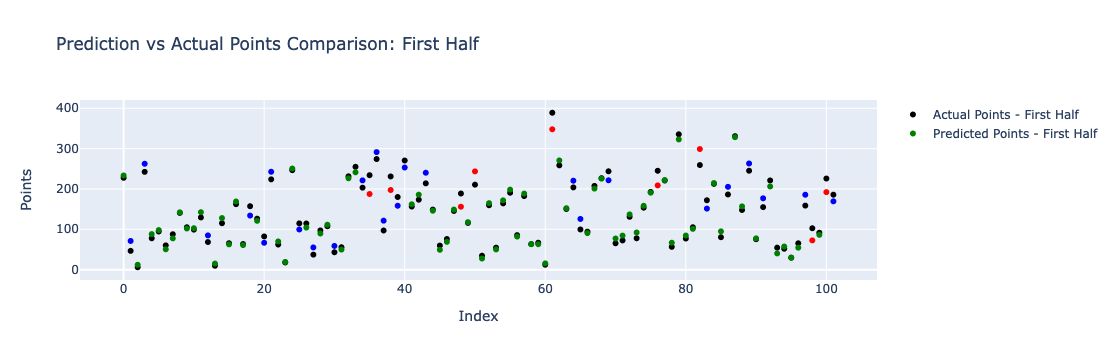

In [54]:
import plotly.graph_objects as go

# Calculate errors and determine colors
errors = abs(predictions - answers)
colors = ['red' if error > 30 else 'green' if error <= 15 else 'blue' for error in errors]

# Get player names and seasons from df_lag using the index from answers
player_names = df_lag.loc[answers.index, 'player_name']  # Adjust 'player_name' as necessary
seasons = df_lag.loc[answers.index, 'season']  # Adjust 'season' as necessary

# Define midpoint to split the data
midpoint = len(answers) // 2

# Create the first plot for the first half
fig1 = go.Figure()
fig1.add_trace(
    go.Scatter(
        x=list(range(midpoint)),
        y=answers[:midpoint],
        mode='markers',
        name='Actual Points - First Half',
        marker=dict(color='black'),
        text=player_names[:midpoint] + " | " + seasons[:midpoint].astype(str),
        hoverinfo='text+y'
    )
)
fig1.add_trace(
    go.Scatter(
        x=list(range(midpoint)),
        y=predictions[:midpoint],
        mode='markers',
        name='Predicted Points - First Half',
        marker=dict(color=colors[:midpoint]),
        text=player_names[:midpoint] + " | " + seasons[:midpoint].astype(str),
        hoverinfo='text+y'
    )
)
fig1.update_layout(
    title='Prediction vs Actual Points Comparison: First Half',
    xaxis_title='Index',
    yaxis_title='Points',
    hovermode='closest'
)

fig1.show()

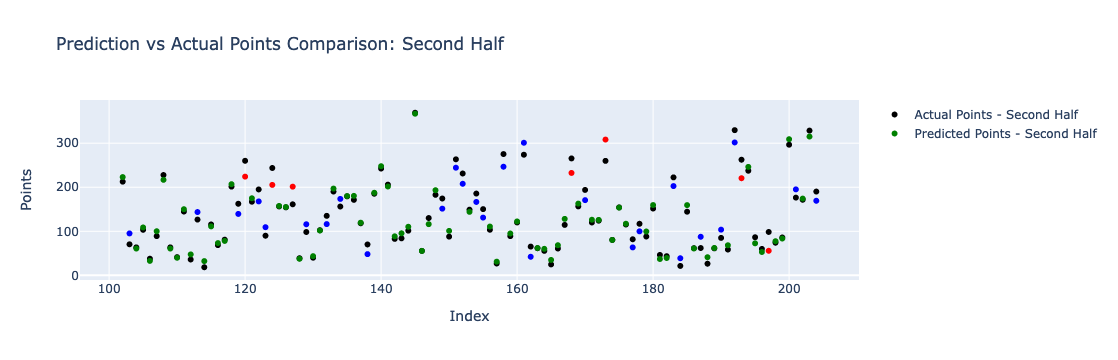

In [55]:
# Create the second plot for the second half
fig2 = go.Figure()
fig2.add_trace(
    go.Scatter(
        x=list(range(midpoint, len(answers))),
        y=answers[midpoint:],
        mode='markers',
        name='Actual Points - Second Half',
        marker=dict(color='black'),
        text=player_names[midpoint:] + " | " + seasons[midpoint:].astype(str),
        hoverinfo='text+y'
    )
)
fig2.add_trace(
    go.Scatter(
        x=list(range(midpoint, len(answers))),
        y=predictions[midpoint:],
        mode='markers',
        name='Predicted Points - Second Half',
        marker=dict(color=colors[midpoint:]),
        text=player_names[midpoint:] + " | " + seasons[midpoint:].astype(str),
        hoverinfo='text+y'
    )
)
fig2.update_layout(
    title='Prediction vs Actual Points Comparison: Second Half',
    xaxis_title='Index',
    yaxis_title='Points',
    hovermode='closest'
)
fig2.show()

## Further Information

In [44]:
predictor.leaderboard(test_data)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-16.236060,-14.159718,root_mean_squared_error,0.096349,0.038658,6.447225,0.001637,0.000282,0.008048,2,True,9
1,CatBoost,-16.593918,-15.389014,root_mean_squared_error,0.003025,0.001265,1.246123,0.003025,0.001265,1.246123,1,True,4
2,ExtraTreesMSE,-17.094906,-15.614186,root_mean_squared_error,0.056734,0.028461,0.272548,0.056734,0.028461,0.272548,1,True,5
3,NeuralNetTorch,-17.617656,-15.881483,root_mean_squared_error,0.006263,0.004713,3.794396,0.006263,0.004713,3.794396,1,True,8
4,RandomForestMSE,-17.679769,-15.349122,root_mean_squared_error,0.076092,0.027686,0.610045,0.076092,0.027686,0.610045,1,True,3
5,NeuralNetFastAI,-17.987210,-15.806779,root_mean_squared_error,0.009331,0.004712,0.788613,0.009331,0.004712,0.788613,1,True,6
6,XGBoost,-19.874489,-17.217632,root_mean_squared_error,0.009692,0.002600,0.772948,0.009692,0.002600,0.772948,1,True,7
7,KNeighborsDist,-40.793421,-39.654683,root_mean_squared_error,0.005107,0.002665,0.170200,0.005107,0.002665,0.170200,1,True,2
8,KNeighborsUnif,-41.131289,-39.704311,root_mean_squared_error,0.009366,0.066880,3.714720,0.009366,0.066880,3.714720,1,True,1


For feature clarification:
- **yptmpa:** receiving yards per team pass attempt

In [45]:
predictor.feature_importance(data=test_data)

These features in provided data are not utilized by the predictor and will be ignored: ['receptions_per_snap']
Computing feature importance via permutation shuffling for 28 features using 205 rows with 5 shuffle sets...
	13.5s	= Expected runtime (2.7s per shuffle set)
	0.92s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
route_proxy,57.946064,2.826754,6.774238e-07,5,63.766389,52.125740
yards_per_snap,17.989780,1.492646,5.635460e-06,5,21.063159,14.916401
yards_per_route_run,16.490275,1.450254,7.105267e-06,5,19.476368,13.504182
target_share_last,0.800123,0.525041,1.354356e-02,5,1.881189,-0.280943
receiving_air_yards_last,0.758436,0.245975,1.160085e-03,5,1.264902,0.251971
air_yards_share_last,0.450222,0.228005,5.776167e-03,5,0.919687,-0.019244
Draft_Round_last,0.399759,0.088996,2.762531e-04,5,0.583003,0.216514
w8dom_last,0.379241,0.151282,2.487237e-03,5,0.690732,0.067749
fantasy_points_ppr_last,0.347574,0.327761,3.835865e-02,5,1.022438,-0.327290
rank_last,0.338609,0.176173,6.333998e-03,5,0.701353,-0.024135
